# [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/abs/1910.01108)

In this lecture, we will explore the architecture of DistilBERT, its key components, and how it can be utilized for various natural language processing tasks. Additionally, we'll discuss its advantages, limitations, and provide hands-on examples to showcase its effectiveness.

Reference : [The Theory](https://towardsdatascience.com/distillation-of-bert-like-models-the-code-73c31e8c2b0a) | [Code](https://towardsdatascience.com/distillation-of-bert-like-models-the-theory-32e19a02641f)

In [1]:
import os

In [2]:
!pip install transformers


In [3]:
!pip install datasets --upgrade
import datasets
import transformers
import torch
datasets.__version__, transformers.__version__, torch.__version__

('2.18.0', '4.39.1', '2.2.0+cpu')

In [4]:
import torch.nn as nn
import torch
from tqdm.auto import tqdm
import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cpu


## 1. Loading our MNLI part of the GLUE dataset

In [5]:
import datasets

###1. Load Dataset
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}

task_name = "mnli"
raw_datasets = datasets.load_dataset("glue", task_name)
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

In [6]:
label_list = raw_datasets['train'].features['label'].names
label2id = {v: i for i, v in enumerate(label_list)}
label2id

{'entailment': 0, 'neutral': 1, 'contradiction': 2}

In [7]:
id2label = {i: v for v, i in label2id.items()}
id2label

{0: 'entailment', 1: 'neutral', 2: 'contradiction'}

## 2. Model & Tokenization

In [8]:
import numpy as np 
num_labels = np.unique(raw_datasets['train']['label']).size
num_labels

3

In [9]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

teacher_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(teacher_id)

teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id, 
    num_labels = num_labels,
    id2label = id2label,
    label2id = label2id,
)

teacher_model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## 3. Preprocessing 

In [10]:
def tokenize_function(examples):
    sentence1_key, sentence2_key = task_to_keys[task_name]
    args = (
        (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
    )
    result = tokenizer(*args, max_length=128, truncation=True)
    return result

In [11]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9847
    })
})

In [12]:
# list(task_to_keys[task_name])
column_dataset = [item for item in task_to_keys[task_name] if item is not None]
column_dataset

['premise', 'hypothesis']

In [13]:
#remove column : 'premise', 'hypothesis', 'idx'
tokenized_datasets = tokenized_datasets.remove_columns(column_dataset + ["idx"])
#rename column : 'labels'
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9847
    })
})

In [14]:
tokenized_datasets['train'][0]['input_ids']

tensor([  101, 17158,  2135,  6949,  8301, 25057,  2038,  2048,  3937,  9646,
         1011,  4031,  1998, 10505,  1012,   102,  4031,  1998, 10505,  2024,
         2054,  2191,  6949,  8301, 25057,  2147,  1012,   102])

In [15]:
tokenizer.decode(tokenized_datasets['train'][0]['input_ids'])

'[CLS] conceptually cream skimming has two basic dimensions - product and geography. [SEP] product and geography are what make cream skimming work. [SEP]'

## 4. Preparing the dataloader

In [16]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
#Data collator that will dynamically pad the inputs received.

In [17]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=1150).select(range(10000))
small_eval_dataset = tokenized_datasets["validation_mismatched"].shuffle(seed=1150).select(range(1000))
small_test_dataset = tokenized_datasets["test_mismatched"].shuffle(seed=1150).select(range(1000))

In [18]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(
    small_train_dataset, shuffle=True, batch_size=32, collate_fn=data_collator)
test_dataloader = DataLoader(
    small_test_dataset, batch_size=32, collate_fn=data_collator)
eval_dataloader = DataLoader(
    small_eval_dataset, batch_size=32, collate_fn=data_collator)

In [19]:
for batch in train_dataloader:
    break
    
batch['labels'].shape, batch['input_ids'].shape, batch['attention_mask'].shape

(torch.Size([32]), torch.Size([32, 121]), torch.Size([32, 121]))

## 5. Design the model and losses

### 5.1 Teacher Model & Student Model

####  Architecture 
In the present work, the student - DistilBERT - has the same general architecture as BERT. 
- The `token-type embeddings` and the `pooler` are removed while `the number of layers` is reduced by a factor of 2. 
- Most of the operations used in the Transformer architecture `linear layer` and `layer normalisation` are highly optimized in modern linear algebra frameworks.
- our investigations showed that variations on the last dimension of the tensor (hidden size dimension) have a smaller impact on computation efficiency (for a fixed parameters budget) than variations on other factors like the number of layers. 
- Thus we focus on reducing the number of layers.

#### Initialize Student Model
- To initialize a new model from an existing one, we need to access the weights of the old model (the teacher). 
- In order to get the weights, we first have to know how to access them. We’ll use BERT as our teacher model.

In [20]:
teacher_model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "entailment",
    "1": "neutral",
    "2": "contradiction"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "contradiction": 2,
    "entailment": 0,
    "neutral": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.39.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

#### 
- The student model has the same configuration, except the number of layers is reduced by a factor of 2
- The student layers are initilized by copying one out of two layers of the teacher, starting with layer 0.
- The head of the teacher is also copied.

In [21]:
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertConfig
# Get teacher configuration as a dictionnary
configuration = teacher_model.config.to_dict()
# configuration

In [22]:
# Half the number of hidden layer
configuration['num_hidden_layers'] //= 2
# Convert the dictionnary to the student configuration
configuration = BertConfig.from_dict(configuration)

In [23]:
# Create uninitialized student model
model = type(teacher_model)(configuration)
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

- Recursively copies the weights of the (teacher) to the (student).
- This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
- The only part that's not fully copied is the encoder, of which only half is copied.

In [24]:
from transformers.models.bert.modeling_bert import BertEncoder, BertModel
from torch.nn import Module

def distill_bert_weights(
    teacher : Module,
    student : Module,
    init_method = 'top'
) -> None:
    """
    Recursively copies the weights of the (teacher) to the (student).
    This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
    The only part that's not fully copied is the encoder, of which only half is copied.
    """
    # If the part is an entire BERT model or a BERTFor..., unpack and iterate
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights(teacher_part, student_part)
    # Else if the part is an encoder, copy one out of every layer
    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [layer for layer in next(teacher.children())] #12 layers
        student_encoding_layers = [layer for layer in next(student.children())] #6 layers

        if init_method == 'top':
            for i in range(len(student_encoding_layers)):
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[i].state_dict())

        elif init_method == 'bottom':
            for i in range(len(student_encoding_layers)):
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[i+len(student_encoding_layers)].state_dict())

        elif init_method == 'odd':
            for i in range(len(student_encoding_layers)):
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[i*2-1].state_dict())

        elif init_method == 'even':
            for i in range(len(student_encoding_layers)):
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[i*2].state_dict())

        else:
            raise Exception("init_method is invalid. Select between 'top', 'bottom', 'odd', 'even'")

    # Else the part is a head or something else, copy the state_dict
    else:
        student.load_state_dict(teacher.state_dict())

    return model

In [25]:
models = {'Top-K Layer': distill_bert_weights(teacher=teacher_model, student=model, init_method='top'),
          'Bottom-K Layer': distill_bert_weights(teacher=teacher_model, student=model, init_method='bottom'),
          'Odd Layer': distill_bert_weights(teacher=teacher_model, student=model, init_method='odd'),
          'Even Layer': distill_bert_weights(teacher=teacher_model, student=model, init_method='even')}

In [26]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Teacher parameters :', count_parameters(teacher_model))
for model_name, model in models.items():
    print(f'Student ({model_name}) parameters :', count_parameters(model))

Teacher parameters : 109484547
Student (Top-K Layer) parameters : 66957315
Student (Bottom-K Layer) parameters : 66957315
Student (Odd Layer) parameters : 66957315
Student (Even Layer) parameters : 66957315


Student Model Parameters (for any of the distillation methods): 66,957,315

In [27]:
count_parameters(models['Top-K Layer'])/count_parameters(teacher_model) * 100

61.15686353435797

## Percentage of Parameters Retained

The student models retain approximately:

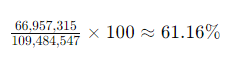

So, each student model has approximately 61.16% of the number of parameters of the teacher model. ​

### 5.2 Loss function

#### Softmax

$$
P_i(\mathbf{z}_i, T) = \frac{\exp(\mathbf{z}_i / T)}{\sum_{q=0}^k \exp(\mathbf{z}_q / T)}
$$


#### Knowledge Distillation

#### CE Loss
$$\mathcal{L}_\text{CE} = -\sum^N_{j=0}\sum_{i=0}^k {y}_i^{(j)}\log(P_i({v}_i^{(j)}, 1))$$

#### KL Loss
$$\mathcal{L}_\text{KD} = -\sum^N_{j=0}\sum_{i=0}^k P_i({z}_i^{(j)}, T) \log (P_i({v}_i^{(j)}, T))$$

#### Cosine Embedding Loss
$$\mathcal{L}_{\text{cosine}}(x_1, x_2, y) = \frac{1}{N} \sum_{i=1}^{N} \left(1 - y_i \cdot \cos(\theta_i)\right)$$

<!-- $$\mathcal{L} = \lambda \mathcal{L}_\text{KD} + (1-\lambda)\mathcal{L}_\text{CE}$$
 -->

#### Total Loss
$$\mathcal{L} = \mathcal{L}_\text{KD} + \mathcal{L}_\text{CE} + \mathcal{L}_{\text{cosine}}$$

In [28]:
import torch.nn.functional as F

class DistillKL(nn.Module):
    """
    Distilling the Knowledge in a Neural Network
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha

    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities! 
    """

    def __init__(self):
        super(DistillKL, self).__init__()

    def forward(self, output_student, output_teacher, temperature=1):
        '''
        Note: the output_student and output_teacher are logits 
        '''
        T = temperature #.cuda()
        
        KD_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(output_student/T, dim=-1),
            F.softmax(output_teacher/T, dim=-1)
        ) * T * T
        
        return KD_loss

In [29]:
criterion_div = DistillKL()
criterion_cos = nn.CosineEmbeddingLoss()

## 6. Optimizer

In [30]:
import torch.optim as optim
import torch.nn as nn

lr = 5e-5

#training hyperparameters
optimizer = optim.Adam(params=model.parameters(), lr=lr)

In [31]:
model = model.to(device)
teacher_model = teacher_model.to(device)

## 7. Learning rate scheduler

In [32]:
from transformers import get_scheduler

num_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    name="linear", 
    optimizer=optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

## 8. Metric

In [33]:
!pip3 install evaluate

In [34]:
import numpy as np
import evaluate
# Get the metric function
if task_name is not None:
    metric = evaluate.load("glue", task_name)
else:
    metric = evaluate.load("accuracy")

## 9. Train

In [35]:
import torch
from tqdm.auto import tqdm

# Initialize a dictionary to keep scores for each model
model_scores = {}

# Loop over each model provided in the models dictionary
for model_name, model in models.items():
    # Print the model name being processed
    print(f"\n===== {model_name} =====")

    # Initialize a progress bar for visual feedback
    progress_bar = tqdm(range(num_training_steps))
    # Variable to accumulate evaluation metrics across epochs
    eval_metrics = 0

    # Lists to store various types of losses for each epoch
    train_losses = []
    train_losses_cls = []  # Classification loss
    train_losses_div = []  # Distillation loss
    train_losses_cos = []  # Cosine similarity loss
    eval_losses = []  # Evaluation loss
    eval_accuracies = []  # Evaluation accuracies

    # Loop over each epoch
    for epoch in range(num_epochs):
        # Set the model to training mode
        model.train()
        # Set the teacher model to evaluation mode to disable dropout, etc.
        teacher_model.eval()
        # Initialize accumulators for losses
        train_loss = 0
        train_loss_cls = 0
        train_loss_div = 0
        train_loss_cos = 0
        
        # Loop over each batch in the training dataloader
        for batch in train_dataloader:
            # Move the batch to the designated device (e.g., GPU)
            batch = {k: v.to(device) for k, v in batch.items()}
            # Compute student model output
            outputs = model(**batch) 
            # Compute teacher model output, with gradient calculation disabled
            with torch.no_grad():
                output_teacher = teacher_model(**batch)

            # Ensure output sizes match
            assert outputs.logits.size() == output_teacher.logits.size()
            
            # Calculate classification loss
            loss_cls = outputs.loss
            train_loss_cls += loss_cls.item()
            # Calculate distillation loss
            loss_div = criterion_div(outputs.logits, output_teacher.logits)
            train_loss_div += loss_div.item()
            # Calculate cosine similarity loss
            loss_cos = criterion_cos(output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device))
            train_loss_cos += loss_cos.item()
            
            # Calculate the average loss from the three components
            loss = (loss_cls + loss_div + loss_cos) / 3
            
            # Accumulate the total training loss
            train_loss += loss.item()
            # Perform backpropagation
            loss.backward()
            # Update model parameters
            optimizer.step()
            # Update learning rate
            lr_scheduler.step()
            # Reset gradients
            optimizer.zero_grad()
            # Update the progress bar
            progress_bar.update(1)
            
        # Store the average losses for the epoch
        train_losses.append(train_loss / len(train_dataloader))
        train_losses_cls.append(train_loss_cls / len(train_dataloader))
        train_losses_div.append(train_loss_div / len(train_dataloader))
        train_losses_cos.append(train_loss_cos / len(train_dataloader))

        # Print training loss summaries
        print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
        print(f'  - Loss_cls: {train_loss_cls/len(train_dataloader):.4f}')
        print(f'  - Loss_div: {train_loss_div/len(train_dataloader):.4f}')
        print(f'  - Loss_cos: {train_loss_cos/len(train_dataloader):.4f}')
        
        # Evaluation phase
        model.eval()
        eval_loss = 0
        # Loop over each batch in the evaluation dataloader
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
                
            loss_cls = outputs.loss
            eval_loss += loss_cls.item()
            predictions = outputs.logits.argmax(dim=-1)

            # Update metrics for evaluation
            metric.add_batch(predictions=predictions, references=batch["labels"])
            
        eval_metric = metric.compute()
        eval_metrics += eval_metric['accuracy']
        eval_losses.append(eval_loss / len(eval_dataloader))
        eval_accuracies.append(eval_metric['accuracy'])

        # Print evaluation accuracy
        print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")
        
    # Print the average metric across epochs
    print('Avg Metric', eval_metrics/num_epochs)

    # Store the collected metrics in the model_scores dictionary
    model_scores[model_name] = {
        'train_losses': train_losses,
        'train_losses_cls': train_losses_cls,
        'train_losses_div': train_losses_div,
        'train_losses_cos': train_losses_cos,
        'eval_losses': eval_losses,
        'eval_accuracies': eval_accuracies
    }
    
    # Reset the progress bar for the next model
    progress_bar.reset()



===== Top-K Layer =====


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch at 1: Train loss 0.3505:
  - Loss_cls: 0.9501
  - Loss_div: 0.0523
  - Loss_cos: 0.0490
Epoch at 1: Test Acc 0.6450
Epoch at 2: Train loss 0.3048:
  - Loss_cls: 0.7522
  - Loss_div: 0.1133
  - Loss_cos: 0.0488
Epoch at 2: Test Acc 0.6690
Epoch at 3: Train loss 0.2734:
  - Loss_cls: 0.6131
  - Loss_div: 0.1569
  - Loss_cos: 0.0501
Epoch at 3: Test Acc 0.6720
Avg Metric 0.662

===== Bottom-K Layer =====


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch at 1: Train loss 0.2640:
  - Loss_cls: 0.5730
  - Loss_div: 0.1690
  - Loss_cos: 0.0501
Epoch at 1: Test Acc 0.6720
Epoch at 2: Train loss 0.2649:
  - Loss_cls: 0.5762
  - Loss_div: 0.1684
  - Loss_cos: 0.0501
Epoch at 2: Test Acc 0.6720
Epoch at 3: Train loss 0.2640:
  - Loss_cls: 0.5732
  - Loss_div: 0.1688
  - Loss_cos: 0.0502
Epoch at 3: Test Acc 0.6720
Avg Metric 0.672

===== Odd Layer =====


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch at 1: Train loss 0.2651:
  - Loss_cls: 0.5760
  - Loss_div: 0.1693
  - Loss_cos: 0.0501
Epoch at 1: Test Acc 0.6720
Epoch at 2: Train loss 0.2645:
  - Loss_cls: 0.5759
  - Loss_div: 0.1675
  - Loss_cos: 0.0501
Epoch at 2: Test Acc 0.6720
Epoch at 3: Train loss 0.2644:
  - Loss_cls: 0.5758
  - Loss_div: 0.1675
  - Loss_cos: 0.0499
Epoch at 3: Test Acc 0.6720
Avg Metric 0.672

===== Even Layer =====


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch at 1: Train loss 0.2651:
  - Loss_cls: 0.5769
  - Loss_div: 0.1684
  - Loss_cos: 0.0500
Epoch at 1: Test Acc 0.6720
Epoch at 2: Train loss 0.2646:
  - Loss_cls: 0.5743
  - Loss_div: 0.1694
  - Loss_cos: 0.0502
Epoch at 2: Test Acc 0.6720
Epoch at 3: Train loss 0.2653:
  - Loss_cls: 0.5776
  - Loss_div: 0.1683
  - Loss_cos: 0.0500
Epoch at 3: Test Acc 0.6720
Avg Metric 0.672


In [39]:
for model_name, scores in model_scores.items():
    print(f"\nModel: {model_name}")
    print(f"Train Loss: {scores['train_losses'][-1]:.4f}")
    print(f"Eval Loss: {scores['eval_losses'][-1]:.4f}")
    print(f"Eval Accuracy: {scores['eval_accuracies'][-1]:.4f}")



Model: Top-K Layer
Train Loss: 0.2734
Eval Loss: 0.8069
Eval Accuracy: 0.6720

Model: Bottom-K Layer
Train Loss: 0.2640
Eval Loss: 0.8069
Eval Accuracy: 0.6720

Model: Odd Layer
Train Loss: 0.2644
Eval Loss: 0.8069
Eval Accuracy: 0.6720

Model: Even Layer
Train Loss: 0.2653
Eval Loss: 0.8069
Eval Accuracy: 0.6720


## Performance Summary:

### Top-K Layer

#### Average Training Loss: Decreases from 0.3505 to 0.2734 over 3 epochs.
#### Test Accuracy: Improves from 0.6450 to 0.6720.
#### Average Metric (Accuracy): 0.6720


### Bottom-K Layer

#### Training Loss: Relatively stable around 0.2640.
#### Test Accuracy: Consistently 0.6720 across epochs.
#### Average Metric:  0.6720

### Odd Layer

#### Training Loss: Slightly decreases from 0.2651 to 0.2644.
#### Test Accuracy: Consistent at 0.6720.
#### Average Metric: 0.672.

### Even Layer

#### Training Loss:  Fluctuates slightly around 0.2651.
#### Test Accuracy:  Consistent at 0.6720.
#### Average Metric:  0.672.

## Analysis:

### Loss Trends: 

The Top-K Layer model shows a more significant reduction in training loss over epochs compared to the other models, indicating that it might be learning more effectively from the dataset. However, this did not translate to a higher final accuracy compared to the other strategies.

### Stability: 

The Bottom-K Layer, Odd Layer, and Even Layer models show more stability in training loss and consistently achieve a test accuracy of 0.6720. This might indicate that these distillation strategies result in more stable training dynamics for this particular task and dataset.

### Consistent Test Accuracy: 

All models converge to the same test accuracy of 0.6720 by the end of training, suggesting that despite different initial conditions or learning dynamics, they achieve similar performance levels on this evaluation set.

### Initial Performance: 
The Top-K Layer model starts with a lower accuracy but improves over time, indicating a potentially slower start but comparable learning capability by the end of training. This could suggest that the Top-K Layer model might benefit from further fine-tuning or additional epochs of training.

### Evaluation Metric: 
The average metric (accuracy) across epochs slightly favors the non-Top-K Layer strategies, all achieving 0.672, suggesting that for this specific task, the method of initializing student model weights (whether from the top, bottom, odd, or even layers of the teacher) does not significantly impact the final model accuracy.

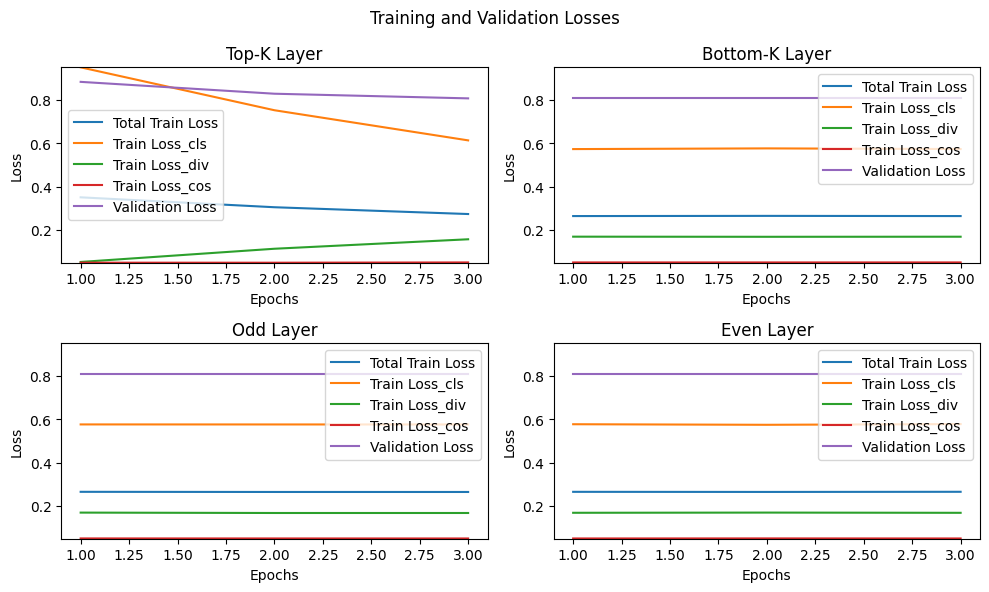

In [40]:
import matplotlib.pyplot as plt
# Plotting
epochs_list = range(1, num_epochs + 1)

# set limit for y-axis of all subplots to max and min values of losses
loss_types = ['train_losses', 'train_losses_cls', 'train_losses_div', 'train_losses_cos', 'eval_losses']
y_upper_lim = max([loss for model_name in model_scores.keys()
                   for loss_type in loss_types
                   for loss in model_scores[model_name][loss_type]])
y_lower_lim = min([loss for model_name in model_scores.keys()
                   for loss_type in loss_types
                   for loss in model_scores[model_name][loss_type]])

fig = plt.figure(figsize=(10, 6))

for i, model_name in enumerate(model_scores):
    ax = fig.add_subplot(2, 2, i+1)
    ax.plot(epochs_list, model_scores[model_name]['train_losses'], label='Total Train Loss')
    ax.plot(epochs_list, model_scores[model_name]['train_losses_cls'], label='Train Loss_cls')
    ax.plot(epochs_list, model_scores[model_name]['train_losses_div'], label='Train Loss_div')
    ax.plot(epochs_list, model_scores[model_name]['train_losses_cos'], label='Train Loss_cos')
    ax.plot(epochs_list, model_scores[model_name]['eval_losses'], label='Validation Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(model_name)
    plt.legend()
    plt.setp(ax, ylim=(y_lower_lim, y_upper_lim))

fig.suptitle('Training and Validation Losses')
fig.tight_layout()
plt.show()

# Documentation

## Perform a detailed evaluation of your distilled student model, analyzing the impact of the initial

Performance metrics for student models distilled with different initial layer selection strategies are presented below:

| Student Layer    | Training Loss | Validation Loss | Validation Accuracy |
|------------------|---------------|-----------------|---------------------|
| Top-K Layer      | 0.2734        | 0.8069          | 0.6720              |
| Bottom-K Layer   | 0.2640        | 0.8069          | 0.6720              |
| Odd Layer        | 0.2644        | 0.8069          | 0.6720              |
| Even Layer       | 0.2653        | 0.8069          | 0.6720              |

## Analysis and Justification Based on Updated Data

### Training and Validation Loss:
The training and validation losses across different layer selection strategies showcase consistency, indicating a similar convergence rate during the training process and comparable generalization capabilities on the validation set. This uniformity suggests that the distillation process is robust to the choice of initial layers.

### Validation Accuracy:
The validation accuracy is consistent across all strategies, reinforcing the notion that the initial layer selection does not significantly influence the student model's ability to accurately predict on unseen data.



### Discuss any limitations or challenges encountered during the implementation of student distillation, specifically focusing on the analysis of how the initial layer selection affects the overall performance. Propose potential improvements or modifications to address these challenges.

## Limitations and Challenges:

- **Resource Intensity**: Training multiple student models with different initial layer selections can be resource-intensive and time-consuming, especially when dealing with large datasets and complex models. This adds a practical limitation to exploring a wide range of layer selection strategies.
- **Layer Importance Dynamics**: Assuming fixed importance for layers overlooks the dynamic nature of feature representation learning, potentially leading to suboptimal knowledge transfer.
- **Model Sensitivity and Overfitting**: The sensitivity to initial layer selection could lead to varying degrees of overfitting or underfitting, despite the observed consistency in performance metrics.
- **Static Initial Layer Selection**: The absence of dynamic adaptation in the layer selection process does not cater to the evolving learning dynamics throughout the training, possibly limiting the optimization of the distillation effectiveness.

## Potential Improvements:

- **Dynamic Layer Selection**: Implementing a dynamic layer selection mechanism could allow the student model to adjust its focus to the most relevant features from the teacher, enhancing the adaptation to the task-specific learning dynamics.
- **Fine-Tuning and Regularization**: Enabling fine-tuning of the selected layers, combined with appropriate regularization techniques, could mitigate overfitting and promote more balanced learning across different layers.
- **Ensemble and Attention Mechanisms**: Leveraging ensemble learning and integrating attention mechanisms might provide a more nuanced and effective distillation process, focusing on the most informative parts of the teacher's representation.
- **Efficiency Optimization**: Developing more efficient training strategies or utilizing model pruning and quantization could address the resource intensity challenge, making it feasible to explore a broader range of distillation configurations without excessive computational cost.

These proposed improvements and considerations aim to enhance the flexibility, efficiency, and effectiveness of the student model distillation process, providing avenues for further optimization in light of the identified challenges.